In [1]:
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter('always', category=UserWarning)

In [3]:
# plot styling 
sns.set_theme(style="whitegrid", palette="bright")
RED = '#e8000b'
GREEN = '#1ac938'
BLUE = '#023eff'
ORANGE = '#ff7c00'

In [4]:
# path to data
OUTPUTS_FOLDER = "outputs"
SYNTHETIC_DATA_FOLDER = "synthetic_data"

In [5]:
SKEW_VALUES = [0, 5, 50]
SCALE_VALUES = [50, 250, 500]
SIZES = ["1k", "10k", "100k", "1M", "10M", "100M", "1B"]

SUB_SIZES = ["1k", "10k", "100k"]

DEFAULT_SKEW = 0
DEFAULT_SCALE = 250
DEFAULT_SIZE = "10k"

SIZES_DICT = {
    "1k": 1000, 
    "10k": 10_000, 
    "100k": 100_000,
    "1M": 1000_000, 
    "10M": 10_000_000,
    "100M": 100_000_000,
    "1B": 1000_000_000
}

QUERIES = ["count", "sum", "mean", "variance"] 

## 1. Plot Synthetic Datasets' Distribution 

In [6]:
FIXED_SIZE = 100000
df_skew_merged = pd.DataFrame()
for skew in SKEW_VALUES:
    df_data = pd.read_csv(f"data/{SYNTHETIC_DATA_FOLDER}/size_{FIXED_SIZE}/data_{FIXED_SIZE}_250_{skew}.csv")
    n = len(df_data)
    df_data["skew"] = [skew]*n
    df_data["scale"] = [250]*n
    df_data["size"] = [FIXED_SIZE]*n
    df_skew_merged = pd.concat([df_skew_merged, df_data], ignore_index=True)
    
df_scale_merged = pd.DataFrame()
for scale in SCALE_VALUES:
    df_data = pd.read_csv(f"data/{SYNTHETIC_DATA_FOLDER}/size_{FIXED_SIZE}/data_{FIXED_SIZE}_{scale}_0.csv")
    n = len(df_data)
    df_data["scale"] = [scale]*n
    df_data["skew"] = [0]*n
    df_data["size"] = [FIXED_SIZE]*n
    df_scale_merged = pd.concat([df_scale_merged, df_data], ignore_index=True)

In [7]:
def plot_facetgrid_sdg(df, column, y_label, xlabel, main_title, sub_title_str):
    sea = sns.FacetGrid(df, col = column)
    sea.map(sns.histplot, "values", binwidth=20, alpha=1, kde=False)
    sea.set_titles(sub_title_str)
    sea.fig.suptitle(main_title, ha='right', va='center', x=1, y=0.5, rotation=270)
    sea.fig.subplots_adjust(top=0.8)
    sea.set_ylabels(y_label)
    sea.set_xlabels(xlabel)
    
    sea.axes[0,0].set_xlabel("")
    sea.axes[0,1].set_xlabel(xlabel)
    sea.axes[0,2].set_xlabel("")

    return sea

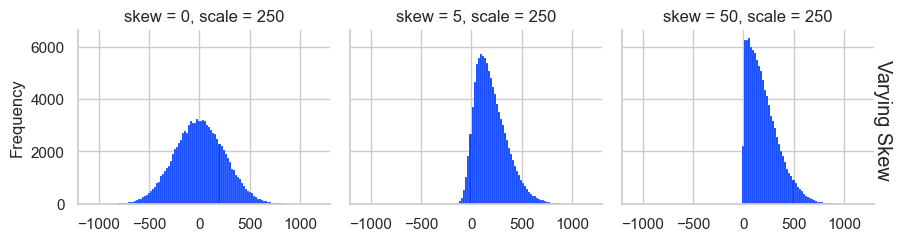

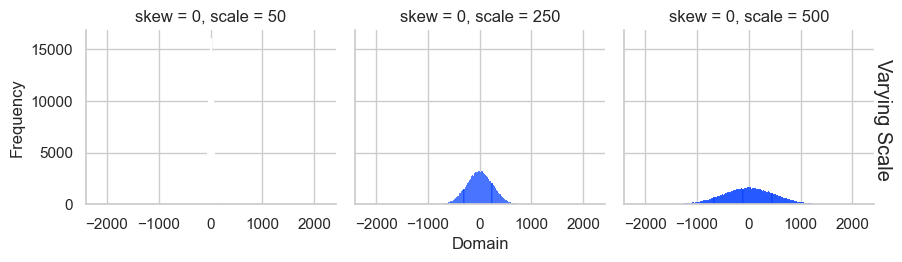

In [22]:
plot_facetgrid_sdg(df_skew_merged, "skew", "Frequency", "", "Varying Skew", "skew = {col_name}, scale = 250")
plot_facetgrid_sdg(df_scale_merged, "scale", "Frequency", "Domain", "Varying Scale", "skew = 0, scale = {col_name}")

## 2. Plot Time Consumption 

In [9]:
def get_time_memory_consumption(sizes, tools):
    d = {"tool": [], "time": [], "size": [], "memory": [], "query": []}

    for tool in tools:
        for query in QUERIES:
            d["tool"].extend([tool]*len(sizes))
            d["query"].extend([query]*len(sizes))
            
            for size in sizes:  
                d["size"].append(size)
                try:
                    path = f"data/{OUTPUTS_FOLDER}/{tool}/{size}/{query}.csv"
                    df = pd.read_csv(path)
                    df = df[(df["dataset_skew"] == DEFAULT_SKEW) & (df["dataset_scale"] == DEFAULT_SCALE)]

                    t = df["mean_time_used"].tolist()
                    m = df["mean_memory_used"].tolist()

                    d["time"].append(sum(t)/len(t))
                    d["memory"].append(sum(m)/len(m))
                except:
                    # case when the process terminated because memory exceeded
                    d["time"].append(np.nan) 
                    d["memory"].append(np.nan)

    return pd.DataFrame(d)

In [10]:
def plot_facetgrid_tm(palette, df, column, y_axis, y_label, sub_title, labels, sizes):
    sea = sns.FacetGrid(df, col = column, hue = "tool", palette=palette)
    sea.map(sns.lineplot, "size", y_axis, marker="o", linewidth = 0.5, estimator=None, ).set(yscale = 'log')
    sea.set_titles("{col_name}")
    sea.fig.suptitle(sub_title)
    sea.fig.subplots_adjust(top=0.8)
    sea.set_ylabels(y_label)
    sea.set_xlabels("")
    
    if len(sizes) == 6:
        sea.set_xticklabels(labels=['$10^{3}$', '$10^{4}$', '$10^{5}$', '$10^{6}$', '$10^{7}$', '$10^{8}$'])
    else:
        sea.set_xticklabels(labels=['$10^{3}$', '$10^{4}$', '$10^{5}$', '$10^{6}$', '$10^{7}$', '$10^{8}$', '$10^{9}$'])

    sea.add_legend(title="", 
                   ncol=3,
                   labels=labels, 
                   bbox_to_anchor=(0.4, -0.08),
                   loc="lower center")        
    return sea

### 2.1. AWS Glue Environment

/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


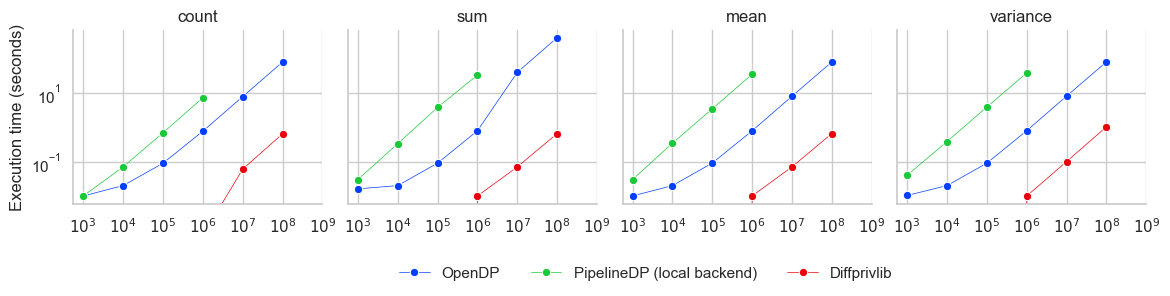

In [11]:
glue_tools = ["opendp", "pipelinedp_local", "diffprivlib"] 
glue_labels = ['OpenDP', 'PipelineDP (local backend)', "Diffprivlib"]
glue_sizes = ["1k", "10k", "100k", "1M", "10M", "100M", "1B"]
palette = [BLUE, GREEN, RED]

df_time_memory = get_time_memory_consumption(glue_sizes, glue_tools)
plot_facetgrid_tm(palette, df_time_memory, "query", "time", "Execution time (seconds)", "", glue_labels, glue_sizes)
# plot_facetgrid_tm(df_time_memory, "query", "memory", "Memory consumption (bytes)", "", glue_labels, glue_sizes)

### 2.2. AWS EMR Environment

/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


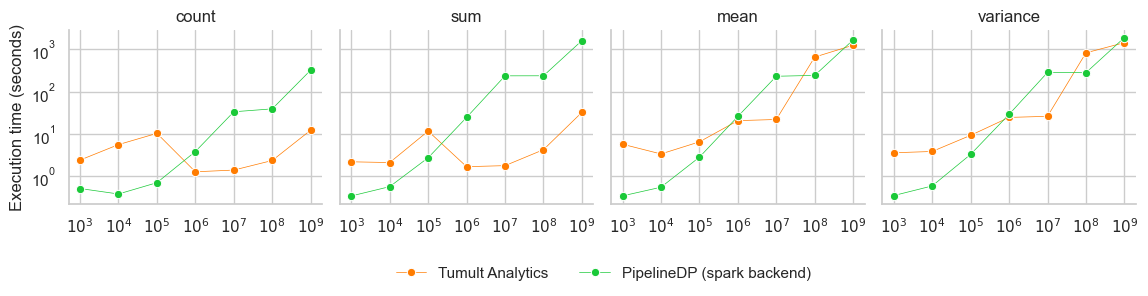

In [12]:
emr_tools = ["tmlt_ana", "pipelinedp_spark"] 
emr_labels = ["Tumult Analytics", 'PipelineDP (spark backend)']
emr_sizes = ["1k", "10k", "100k", "1M", "10M", "100M", "1B"]
palette = [ORANGE, GREEN]

df_time_memory = get_time_memory_consumption(emr_sizes, emr_tools)
plot_facetgrid_tm(palette, df_time_memory, "query", "time", "Execution time (seconds)", "", emr_labels, emr_sizes)

## 3. Plot Utility Analaysis 

In [13]:
def get_query_out_vary_size(query, tools, skew, scale):
    df_merged = pd.DataFrame()

    for size in SUB_SIZES:
        for tool in tools:
            try:
                path = f"data/{OUTPUTS_FOLDER}/{tool}/{size}/{query}.csv"
                df = pd.read_csv(path)
                df = df[(df["dataset_skew"] == skew) & (df["dataset_scale"] == scale) & (df["epsilon"] <= EPSILON_LIMIT) ]
                df["tool"] = [tool]*len(df)
                df_merged = pd.concat([df_merged, df], ignore_index=True)
            except:
                pass
    return df_merged

In [14]:
def get_query_out_vary_scale(query, tools, skew, size):
    df_merged = pd.DataFrame()

    for tool in tools:
        try:
            path = f"data/{OUTPUTS_FOLDER}/{tool}/{size}/{query}.csv"
            df = pd.read_csv(path)
            df = df[(df["dataset_skew"] == skew)  & (df["epsilon"] <= EPSILON_LIMIT) ]
            df["tool"] = [tool]*len(df)
            df_merged = pd.concat([df_merged, df], ignore_index=True)
        except:
            pass
    return df_merged

In [15]:
def get_query_out_vary_skew(query, tools, scale, size):

    df_merged = pd.DataFrame()

    for tool in tools:
        try:
            path = f"data/{OUTPUTS_FOLDER}/{tool}/{size}/{query}.csv"
            df = pd.read_csv(path)
            df = df[(df["dataset_scale"] == scale)  & (df["epsilon"] <= EPSILON_LIMIT) ]
            df["tool"] = [tool]*len(df)
            df_merged = pd.concat([df_merged, df], ignore_index=True)
        except:
            pass
    return df_merged

In [16]:
def plot_facetgrid(df, x_label, y_label, column, variable, sub_title, labels, show_legend=False):
    sea = sns.FacetGrid(df, col = column, hue = "tool")
    y_axis =  "mean_relative_error" 
    sea.map(sns.lineplot, "epsilon", y_axis, alpha = 1,  linewidth = 1.6).set(xscale = 'log')

    f = f"{variable}"
    sea.set_titles(f + " = {col_name}")
    if y_label:
        sea.set_ylabels(" ".join(y_label.split("_")))
    else:
        sea.set_ylabels(" ")
        
    sea.set_xlabels(x_label)
    sea.axes[0,0].xaxis.label.set_visible(False)
    sea.axes[0,2].xaxis.label.set_visible(False)
    
    if show_legend:
        sea.add_legend(title="", labels=labels)
        
    sea.fig.suptitle(sub_title, size=13, ha="center", va="center")    
    sea.fig.subplots_adjust(top=0.8, wspace=0, hspace=0)
    

    
    return sea

In [17]:
EPSILON_LIMIT = 10

tools = ["opendp", "tmlt_ana", "pipelinedp_local", "diffprivlib"]
labels = ['OpenDP', "Tumult analytics", 'PipelineDP', "Diffprivlib"]

### 3.1. Count Query

/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


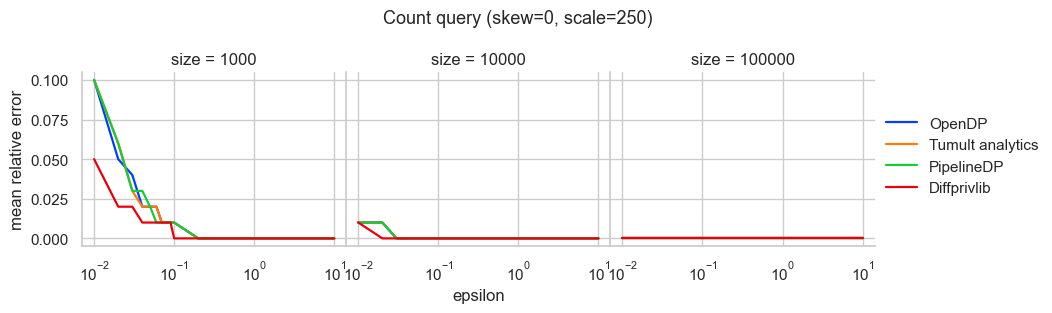

In [18]:
evaluate_query = "COUNT"

DEFAULT_SKEW = 0
DEFAULT_SCALE = 250
DEFAULT_SIZE = "10k"

# SIZE DIVERSITY
df_vary_size = get_query_out_vary_size(evaluate_query, tools, DEFAULT_SKEW, DEFAULT_SCALE)
plot_facetgrid(df_vary_size, "epsilon", "mean_relative_error", "dataset_size", "size", f"{evaluate_query.title()} query (skew={DEFAULT_SKEW}, scale={DEFAULT_SCALE})", labels, True)

### 3.2. Sum Query

/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


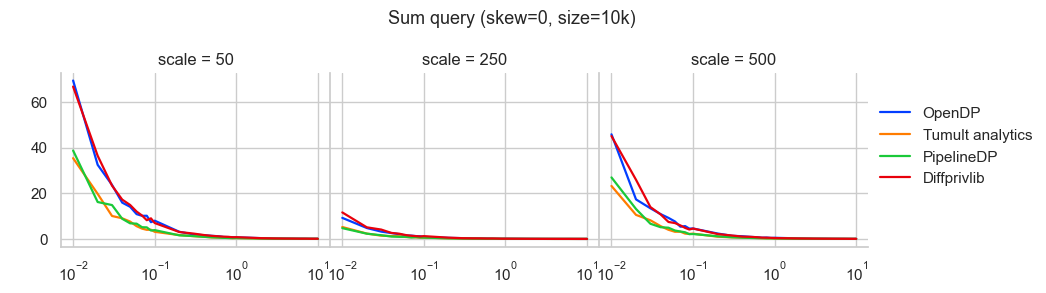

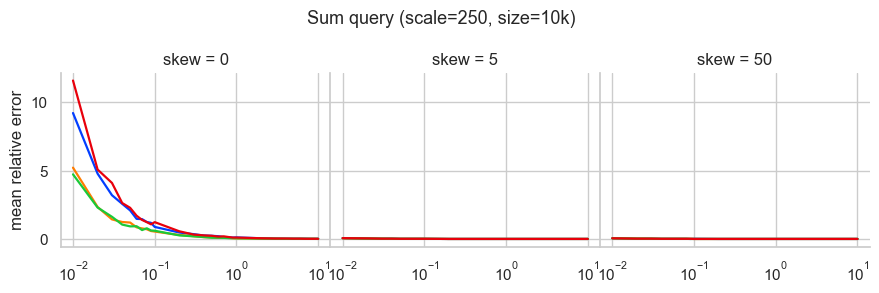

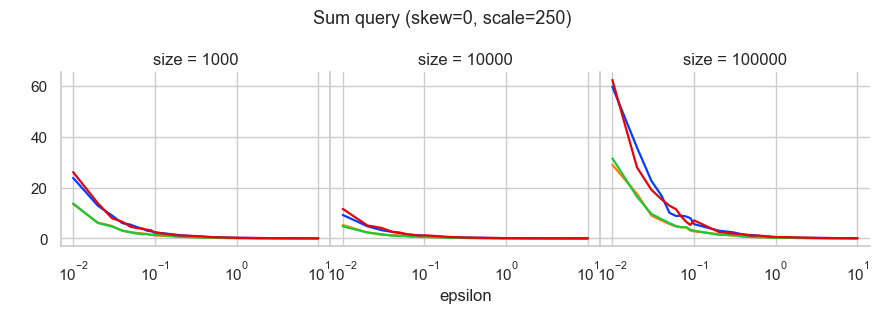

In [19]:
evaluate_query = "SUM"

# SCALE DIVERSITY
df_vary_scale = get_query_out_vary_scale(evaluate_query, tools, DEFAULT_SKEW, DEFAULT_SIZE)
plot_facetgrid(df_vary_scale, "", "", "dataset_scale", "scale", f"{evaluate_query.title()} query (skew={DEFAULT_SKEW}, size={DEFAULT_SIZE})", labels, True)

# SKEW DIVERSITY
df_vary_skew = get_query_out_vary_skew(evaluate_query, tools, DEFAULT_SCALE, DEFAULT_SIZE)
plot_facetgrid(df_vary_skew, "", "mean_relative_error", "dataset_skew", "skew", f"{evaluate_query.title()} query (scale={DEFAULT_SCALE}, size={DEFAULT_SIZE})", labels)

# SIZE DIVERSITY
df_vary_size = get_query_out_vary_size(evaluate_query, tools, DEFAULT_SKEW, DEFAULT_SCALE)
plot_facetgrid(df_vary_size, "epsilon", "", "dataset_size", "size", f"{evaluate_query.title()} query (skew={DEFAULT_SKEW}, scale={DEFAULT_SCALE})", labels)

### 3.3. Mean Query

/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


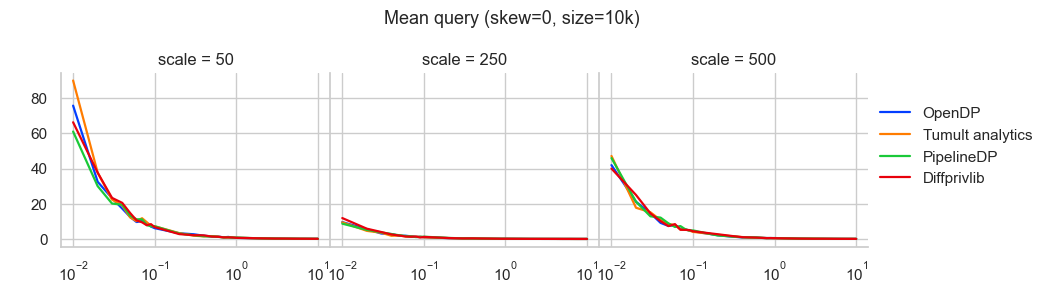

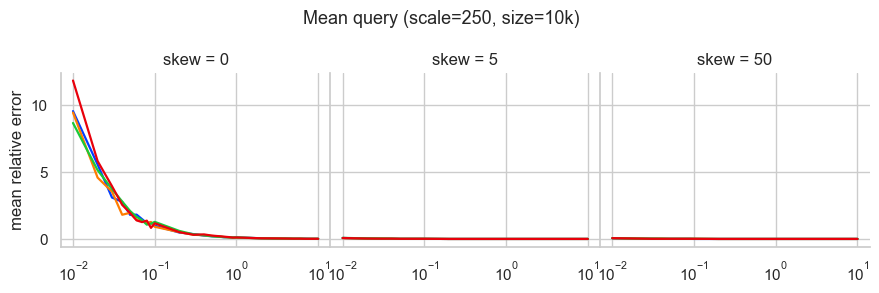

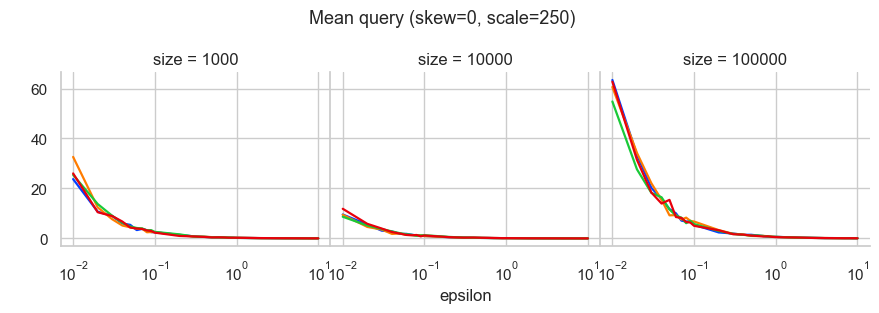

In [20]:
evaluate_query = "MEAN"

# SCALE DIVERSITY
df_vary_scale = get_query_out_vary_scale(evaluate_query, tools, DEFAULT_SKEW, DEFAULT_SIZE)
plot_facetgrid(df_vary_scale, "", "", "dataset_scale", "scale", f"{evaluate_query.title()} query (skew={DEFAULT_SKEW}, size={DEFAULT_SIZE})", labels, True)

# SKEW DIVERSITY
df_vary_skew = get_query_out_vary_skew(evaluate_query, tools, DEFAULT_SCALE, DEFAULT_SIZE)
plot_facetgrid(df_vary_skew, "", "mean_relative_error", "dataset_skew", "skew", f"{evaluate_query.title()} query (scale={DEFAULT_SCALE}, size={DEFAULT_SIZE})", labels)

# SIZE DIVERSITY
df_vary_size = get_query_out_vary_size(evaluate_query, tools, DEFAULT_SKEW, DEFAULT_SCALE)
plot_facetgrid(df_vary_size, "epsilon", "", "dataset_size", "size", f"{evaluate_query.title()} query (skew={DEFAULT_SKEW}, scale={DEFAULT_SCALE})", labels)

### 3.4. Variance Query

/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


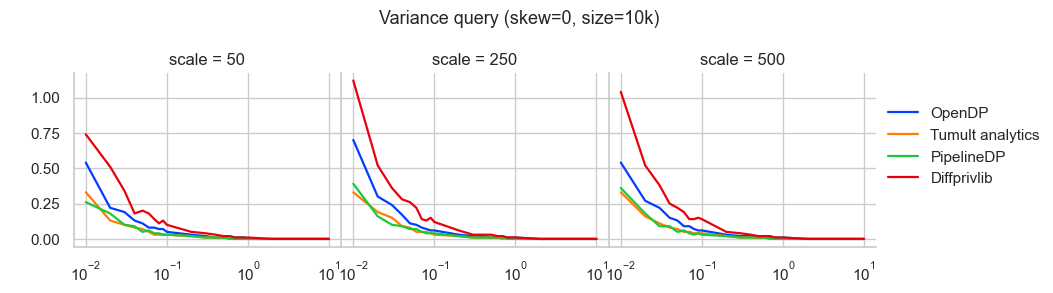

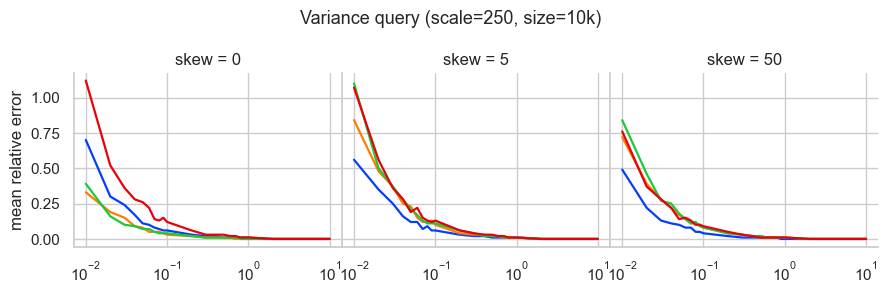

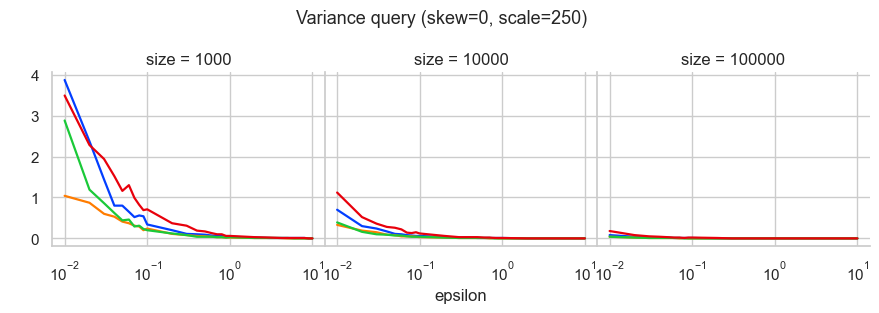

In [23]:
evaluate_query = "VARIANCE"

# SCALE DIVERSITY
df_vary_scale = get_query_out_vary_scale(evaluate_query, tools, DEFAULT_SKEW, DEFAULT_SIZE)
plot_facetgrid(df_vary_scale, "", "", "dataset_scale", "scale", f"{evaluate_query.title()} query (skew={DEFAULT_SKEW}, size={DEFAULT_SIZE})", labels, True)

# SKEW DIVERSITY
df_vary_skew = get_query_out_vary_skew(evaluate_query, tools, DEFAULT_SCALE, DEFAULT_SIZE)
plot_facetgrid(df_vary_skew, "", "mean_relative_error", "dataset_skew", "skew", f"{evaluate_query.title()} query (scale={DEFAULT_SCALE}, size={DEFAULT_SIZE})", labels)

# SIZE DIVERSITY
df_vary_size = get_query_out_vary_size(evaluate_query, tools, DEFAULT_SKEW, DEFAULT_SCALE)
plot_facetgrid(df_vary_size, "epsilon", "", "dataset_size", "size", f"{evaluate_query.title()} query (skew={DEFAULT_SKEW}, scale={DEFAULT_SCALE})", labels)